# Examples of models training and validation

For crop prediction 2 models are implemented:
* CropNet - time series data processing with LSTM.
* CropNet2 - time series data processing with CNN.

In [3]:
import os
import toml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, Subset
from torchvision.models.resnet import resnet18
from torchvision import transforms

from models.crop_model import CropNet
from models.crop_model_2 import CropNet2

from dataloader.dataloader import BandsYieldDataset
from models.train_utils import forward, evaluate, train_model, train_monitor
from dataloader.data_utils import get_band_to_idx, compose_transforms, create_augmentations
from dataloader.augmentations import Flip, Rotate, Crop, CutOut, MixUp

In [4]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_seed(123)

In [5]:
DATA_PATH = './data'

TRAIN_FULL_CSV_PATH = os.path.join(DATA_PATH, 'train_df_full.csv')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'image_arrays_train')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'image_arrays_test')
BANDS_TXT = os.path.join(DATA_PATH, 'bandnames.txt')

# Data preparation

In [15]:
# Load configs
cfg_data = toml.load('./configs/dataloader_cfg_cropnet.toml')
cfg_model = toml.load('./configs/models_cfg.toml')
cfg_bands = toml.load('./configs/bands_cfg.toml')

Data split:

In [7]:
train_df = pd.read_csv(TRAIN_FULL_CSV_PATH)

train, val = train_test_split(train_df, test_size=0.2, random_state=123)

train.to_csv(f'{DATA_PATH}/train_subset.csv', index=False)
val.to_csv(f'{DATA_PATH}/val_subset.csv', index=False)

In [8]:
dataloader_transforms = compose_transforms(cfg_data)
augmentations = create_augmentations(cfg_data)

train_dataset = BandsYieldDataset(
    f'{DATA_PATH}/train_subset.csv',
    TRAIN_DATA_PATH,
    dataloader_transforms,
    augmentations,
    cfg_bands,
    cfg_data
  )

val_dataset = BandsYieldDataset(
    f'{DATA_PATH}/val_subset.csv',
    TRAIN_DATA_PATH,
    dataloader_transforms,
    None,
    cfg_bands,
    cfg_data
  )

train_dataloader = DataLoader(train_dataset,
                              batch_size=cfg_data['data_loader']['batch_size'],
                              shuffle=cfg_data['data_loader']['shuffle'],
                              num_workers=cfg_data['data_loader']['num_workers'])

val_dataloader = DataLoader(val_dataset,
                            batch_size=cfg_data['data_loader']['batch_size'],
                            shuffle=cfg_data['data_loader']['shuffle'],
                            num_workers=cfg_data['data_loader']['num_workers'])

# CropNet

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

model = CropNet(cfg_data, cfg_model, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=cfg_model['train_params']['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9, verbose=True)
criterion = nn.MSELoss(reduction='mean')

Device: cuda:0
Adjusting learning rate of group 0 to 1.0000e-03.


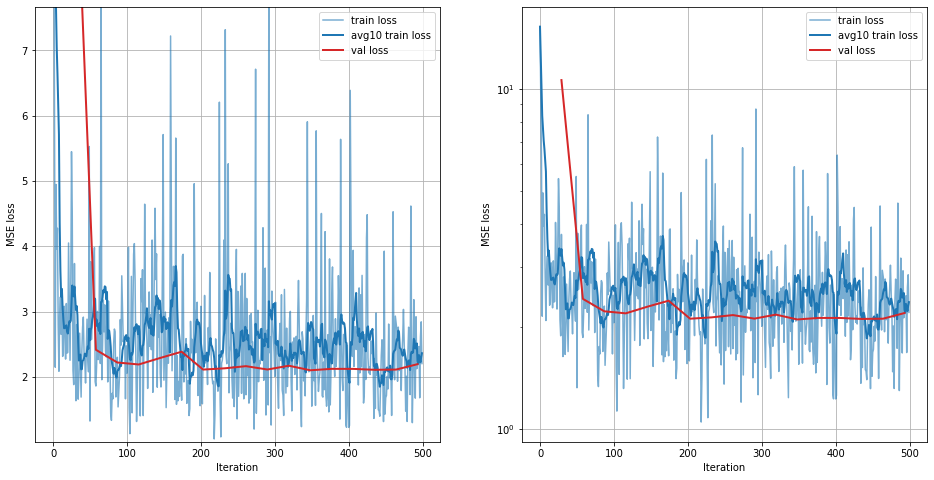

loss: 2.20483, avg loss: 2.60939: 100%|██████████| 500/500 [55:46<00:00,  6.69s/it]


In [10]:
train_model(model,
           train_dataloader,
           val_dataloader,
           device,
           optimizer,
           criterion,
           scheduler,
           cfg_data,
           cfg_model)

# CropNet2

In [16]:
cfg_data = toml.load('./configs/dataloader_cfg_cropnet2.toml')

In [17]:
dataloader_transforms = compose_transforms(cfg_data)
augmentations = create_augmentations(cfg_data)

train_dataset = BandsYieldDataset(
    f'{DATA_PATH}/train_subset.csv',
    TRAIN_DATA_PATH,
    dataloader_transforms,
    augmentations,
    cfg_bands,
    cfg_data
  )

val_dataset = BandsYieldDataset(
    f'{DATA_PATH}/val_subset.csv',
    TRAIN_DATA_PATH,
    dataloader_transforms,
    None,
    cfg_bands,
    cfg_data
  )

train_dataloader = DataLoader(train_dataset,
                              batch_size=cfg_data['data_loader']['batch_size'],
                              shuffle=cfg_data['data_loader']['shuffle'],
                              num_workers=cfg_data['data_loader']['num_workers'])

val_dataloader = DataLoader(val_dataset,
                            batch_size=cfg_data['data_loader']['batch_size'],
                            shuffle=cfg_data['data_loader']['shuffle'],
                            num_workers=cfg_data['data_loader']['num_workers'])

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

model = CropNet2(cfg_data, cfg_model, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=cfg_model['train_params']['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9, verbose=True)
criterion = nn.MSELoss(reduction='mean')

Device: cuda:0
Adjusting learning rate of group 0 to 1.0000e-03.


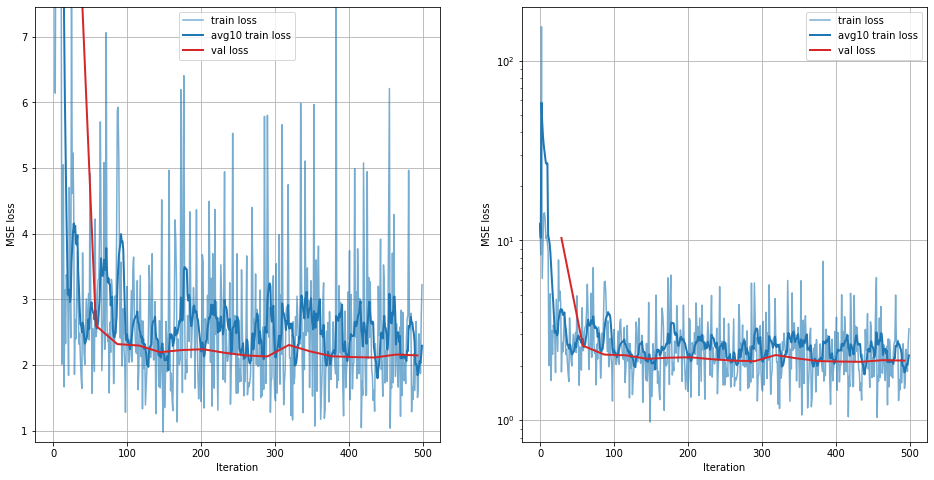


loss: 3.22368, avg loss: 3.08409: 100%|██████████| 500/500 [22:05<00:00,  2.65s/it]


In [19]:
train_model(model,
           train_dataloader,
           val_dataloader,
           device,
           optimizer,
           criterion,
           scheduler,
           cfg_data,
           cfg_model)